This notebook is to document the implementation of cold deciduous only vegetation in FATES.

The runs here use two identical PFTs cloned from the "broadleaf_colddecid_extratrop_tree" in the default FATES file. (PFT#6) 

I noticed previously that there were some odd issues with this PFT dominating the tropical regions, and so wanted to see how they would behave in the absence of any competitors... The answer, as usual for these sorts of things was 'interesting'. 

Hopefully this little story should at least point to a plausible set of solutions, (spoiler alert: I haven't figured it out yet.) 

So, in the beginning, we have some magic python libraries...

In [1]:
%matplotlib inline
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import xarray as xr
from matplotlib import pyplot as plt
import datetime
import cartopy
import cartopy.crs as ccrs

Then we choose which simulations to use...

In [2]:
runs = ['clm5-fates_napi5_CLD','clm5-fates_napi5_CLD_dailyout','clm5-fates_ryanfix_CLD',\
        'clm5-fates_ryanfix_CLD_daily', 'clm5-fates_rosiefix_CLD_daily','clm5-fates_rosiefix_counter_CLD_daily',\
       'clm5-fates_rosiefix_counter_gddz_CLD_daily']

Then we make an ugly list of variables to ignore (the files being large)

(n.b. does anyone know how to make this inclusive rather than exclusive? 
Reading in >10 years of 4x5 output takes nearly forever)

In [3]:
drop={'ACTUAL_IMMOB','ATM_TOPO','BCDEP','BTRAN','CBALANCE_ERROR_BGC','CBALANCE_ERROR_ED','CBALANCE_ERROR_TOTAL',
      'CWD_STOCK_COL','C_LBLAYER','C_STOMATA','DENIT','DSL','DSTDEP','DSTFLXT','EFLXBUILD','EFLX_DYNBAL',
      'EFLX_GRND_LAKE','EFLX_LH_TOT','EFLX_LH_TOT_R','EFLXBUILD','EFLX_DYNBAL','EFLX_GRND_LAKE','EFLX_LH_TOT',
      'EFLX_LH_TOT_R','ERRH2O','ERRH2OSNO','ERRSEB','ERRSOI','FCEV','FCOV','FCTR','FFIX_TO_SMINN','FGEV','FGR',
      'FGR12','FH2OSFC','FIRA','FIRA_R','FIRE','FSA','FSAT','FSDS','FSDSND','FSDSNDLN','FSDSNI','FSDSVD','FSDSVDLN',
      'FSDSVI','FSDSVILN','FSH','FSH_PRECIP_CONVERSION','FSH_G','FSH_R','FSH_RUNOFF_ICE_TO_LIQ','FSH_TO_COUPLER',
      'FSH_V','FSM','FSNO','FSNO_EFF','FSR','FSRND','FSRNDLN','FSRNI','FSRVD','FSRVDLN','FSRVI','GROSS_NMIN','H2OCAN',
      'H2OSNO_TOP','HEAT_CONTENT1','HEAT_FROM_AC','HIA','HIA_R','HIA_U','HUMIDEX','HUMIDEX_R','HUMIDEX_U',
      'ICE_CONTENT1','LAKEICEFRAC_SURF','LAKEICETHICK','LIQUID_CONTENT1','LITR1N','LITR1N_vr','LITR2N','LITR2N_vr',
      'LITR3N','LITR3N_vr','NDEP_TO_SMINN','NET_NMIN','O_SCALAR','PARVEGLN','PBOT','PCT_GLC_MEC','POTENTIAL_IMMOB',
      'QCHARGE','QDRAI','QDRAI_PERCH','QDRAI_XS','QDRIP','QFLOOD','QFLOOD','QFLX_DEW_GRND','QFLX_DEW_SNOW',
      'QFLX_EVAP_TOT','QFLX_ICE_DYNBAL','QFLX_LIQ_DYNBAL','QFLX_SNOW_DRAIN','QFLX_SNOW_DRAIN_ICE','QFLX_SUB_SNOW',
      'QH2OSFC','QICE','QICE_FRZ','QICE_MELT','QINFL','QINTR','QIRRIG','QOVER','QRGWL','QRUNOFF','QRUNOFF_ICE',
      'QRUNOFF_TO_COUPLER','QSNOCPLIQ','QSNOFRZ','QSNOFRZ_ICE','QSNOMELT','QSNOMELT_ICE','QSNO_TEMPUNLOAD',
      'QSNO_WINDUNLOAD','QSNWCPICE', 'QSOIL_ICE','SABG_PEN','SABV','SMINN','SMINN_LEACHED','SMINN_TO_PLANT',
      'SNOBCMCL','SNOBCMSL','SNOCAN','SNODSTMCL','SNODSTMSL','SNOFSRND','SNOFSRND','SNOFSRVD','SNOFSRVI',
      'SNOINTABS','SNOOCMCL','SNOOCMSL','SNOTXMASS','SNOUNLOAD','SNOW_PERSISTENCE','SNOW_SINKS','SNOW_SOURCES',
      'SOIL1N','SOIL1N_vr','SOIL2N','SOIL2N_vr','SOIL3N','SOIL3N_vr','SOILC_HR','SOILICE','SOILLIQ','SOILRESIS',
      'SOILWATER_10CM','SOM_C_LEACHED','SUPPLEMENT_TO_SMINN','SWBGT','SWBGT_U','TAUX','TAUY','TKE1','TLAKE',
      'TREFMNAV','TREFMXAV','TSOI_ICE','T_SCALAR','U10','U10_DUST','URBAN_AC','URBAN_HEAT','VOLR','VOLRMCH',
      'WASTEHEAT','WBT','WBT_R','WBT_U','W_SCALAR','ZBOT','ZWT','ZWT_PERCH'}

Read data from the archive: (but only the first 10 years for the sake of the aforementioned slowness)

First the control and then the fix

In [4]:
run = runs[3]
scratch = '/glade/scratch/rfisher/'
arc = scratch + 'archive/' + run + '/lnd/hist/'
#arc = scratch + '/' + run + '/run/' 
print(arc)
f1=(arc +run+'.clm2.h0.2001-01-01-00000.nc')
f2=(arc +run+'.clm2.h0.2002-01-01-00000.nc')
f3=(arc +run+'.clm2.h0.2003-01-01-00000.nc')
f4=(arc +run+'.clm2.h0.2004-01-01-00000.nc')
ds0 = xr.open_mfdataset([f2,f3], drop_variables=drop, decode_times=False)
#ds_2003 = xr.open_mfdataset(arc + '2003*', drop_variables=drop, decode_times=False)
arc = scratch + 'archive/' + run + '/lnd/hist/'+ run + '.clm2.h0.' 
#arc = scratch + '/' + run + '/run/' + run + '.clm2.h0.' 
#ds0= xr.open_mfdataset(arc + '2002*', drop_variables=drop, decode_times=False)


/glade/scratch/rfisher/archive/clm5-fates_rosiefix_counter_CLD_daily/lnd/hist/


In [5]:
run = runs[4]
scratch = '/glade/scratch/rfisher/'
arc = scratch + 'archive/' + run + '/lnd/hist/'
arc = scratch + run + '/run/'
print(arc)
f1=(arc +run+'.clm2.h0.2001-01-01-00000.nc')
f2=(arc +run+'.clm2.h0.2002-01-01-00000.nc')
f3=(arc +run+'.clm2.h0.2003-01-01-00000.nc')
f4=(arc +run+'.clm2.h0.2004-01-01-00000.nc')
ds1 = xr.open_mfdataset([f2,f3], drop_variables=drop, decode_times=False)

arc = scratch + 'archive/' + run + '/lnd/hist/'+ run + '.clm2.h0.' 
arc = scratch + '/' + run + '/run/' + run + '.clm2.h0.' 
print(arc)
#ds1 = xr.open_mfdataset(arc + '2002*', drop_variables=drop, decode_times=False)
#ds_2003 = xr.open_mfdataset(arc + '2003*', drop_variables=drop, decode_times=False)

/glade/scratch/rfisher/clm5-fates_rosiefix_counter_gddz_CLD_daily/run/
/glade/scratch/rfisher//clm5-fates_rosiefix_counter_gddz_CLD_daily/run/clm5-fates_rosiefix_counter_gddz_CLD_daily.clm2.h0.


In [6]:
yr1=2
yr2=4

Plot tropical LAI patterns that were troublesome before. These look a lot better. 

Now have a look at the global LAI plot... This doesn't seem to have enough LAI in the high latitudes. 

<xarray.DataArray 'TLAI' (time: 730, lat: 46, lon: 72)>
dask.array<shape=(730, 46, 72), dtype=float32, chunksize=(365, 46, 72)>
Coordinates:
  * lon      (lon) float32 0.0 5.0 10.0 15.0 20.0 ... 340.0 345.0 350.0 355.0
  * lat      (lat) float32 -90.0 -86.0 -82.0 -78.0 -74.0 ... 78.0 82.0 86.0 90.0
  * time     (time) float64 730.0 731.0 732.0 ... 1.457e+03 1.458e+03 1.459e+03
Attributes:
    long_name:     total projected leaf area index
    units:         none
    cell_methods:  time: mean


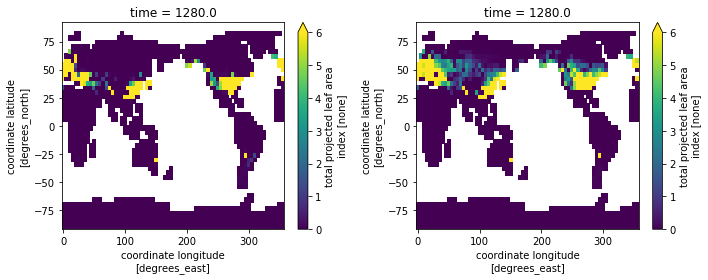

In [7]:
plt.rcParams['figure.figsize'] = [10, 4]
fig,([ax0, ax1]) = plt.subplots(ncols=2, nrows=1)
print(ds0.TLAI)
t=ds1.TLAI.sizes['time']-100
t=550
ds0.TLAI[t,:,:].plot(ax=ax0,vmax=5)
ds1.TLAI[t,:,:].plot(ax=ax1,vmax=5)
plt.tight_layout()


Lets plot some LAI from the high lats

range(36, 37)


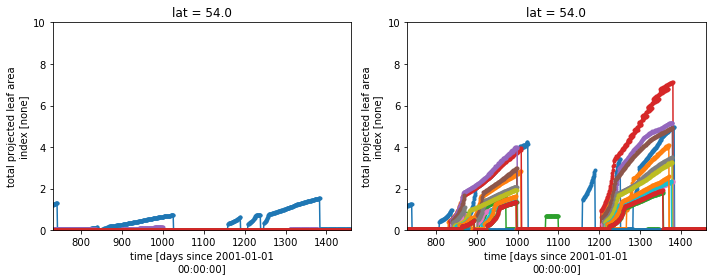

In [8]:
plt.rcParams['figure.figsize'] = [10, 4]
fig,([ax0, ax1]) = plt.subplots(ncols=2, nrows=1)
lats=range(36,37)
lons=range(46,60)
xmn=365*yr1
xmx=365*yr2
ymx=10
for l in lats:
   ds0.TLAI.isel(lat=l,  lon=lons).plot.line(ax=ax0,x='time',add_legend=False, xlim=(xmn,xmx), marker='.', ylim=(0,ymx))
   ds1.TLAI.isel(lat=l,  lon=lons).plot.line(ax=ax1,x='time',add_legend=False, xlim=(xmn,xmx), marker='.', ylim=(0,ymx))
plt.tight_layout()
print(lats)

Plot first four years of timeseries. Noting that the resurgence of LAI doesn't happen in the new version. 

Now check that we haven't broken anything else... Here are all the LAI sequences. 

So far, so good. Here are the maps of LAI. It seems pretty low in the high latitudes...

PLotting out some of the high latitude places. The LAI is essentially missing in the second year for most points (and later years also more or less, not shown)

Looking at the dynamics of stored and leaf carbon for the beginning for the high lat points. Some points have the expected dynamics, others seem to lose carbon from the store, but not put it back into the leaf? 

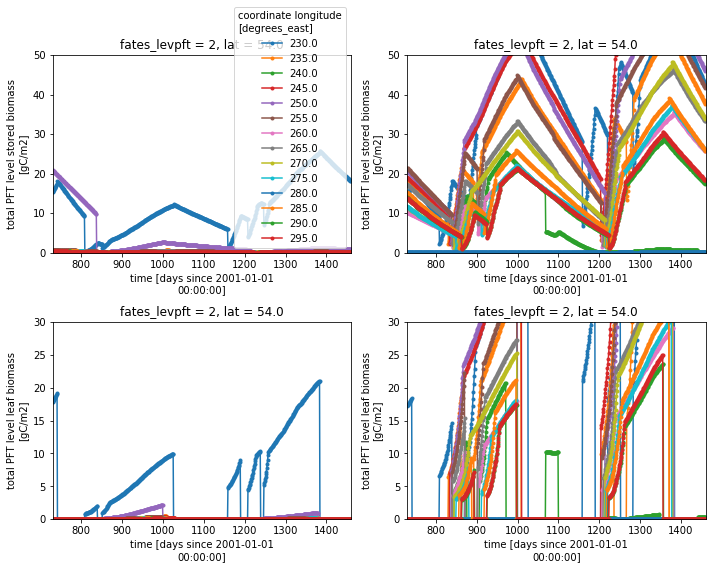

In [9]:
plt.rcParams['figure.figsize'] = [10, 8]
fig,([ax0, ax1],[ax2, ax3]) = plt.subplots(ncols=2, nrows=2)
lats=range(36,37)
lons=range(46,60)
xmn=365*yr1
xmx=365*yr2
ymx=50
ymx2=30
for l in lats:
   ds0.PFTstorebiomass.isel(lat=l,  lon=lons, fates_levpft=1).plot.line(ax=ax0,x='time', xlim=(xmn,xmx), marker='.',ylim=(0,ymx))
   ds1.PFTstorebiomass.isel(lat=l,  lon=lons, fates_levpft=1).plot.line(ax=ax1,x='time',add_legend=False, xlim=(xmn,xmx), marker='.', ylim=(0,ymx))
   ds0.PFTleafbiomass.isel(lat=l,   lon=lons, fates_levpft=1).plot.line(ax=ax2,x='time',add_legend=False, xlim=(xmn,xmx), marker='.', ylim=(0,ymx2))
   ds1.PFTleafbiomass.isel(lat=l,   lon=lons, fates_levpft=1).plot.line(ax=ax3,x='time',add_legend=False, xlim=(xmn,xmx), marker='.', ylim=(0,ymx2))
plt.tight_layout()


In [10]:
print(ds1.M6_SCLS)

<xarray.DataArray 'M6_SCLS' (time: 730, fates_levscls: 13, lat: 46, lon: 72)>
dask.array<shape=(730, 13, 46, 72), dtype=float32, chunksize=(365, 13, 46, 72)>
Coordinates:
  * fates_levscls  (fates_levscls) float32 0.0 5.0 10.0 15.0 ... 80.0 90.0 100.0
  * lon            (lon) float32 0.0 5.0 10.0 15.0 ... 340.0 345.0 350.0 355.0
  * lat            (lat) float32 -90.0 -86.0 -82.0 -78.0 ... 78.0 82.0 86.0 90.0
  * time           (time) float64 730.0 731.0 732.0 ... 1.458e+03 1.459e+03
Attributes:
    long_name:     termination mortality by size
    units:         N/ha/yr
    cell_methods:  time: mean


range(36, 37)


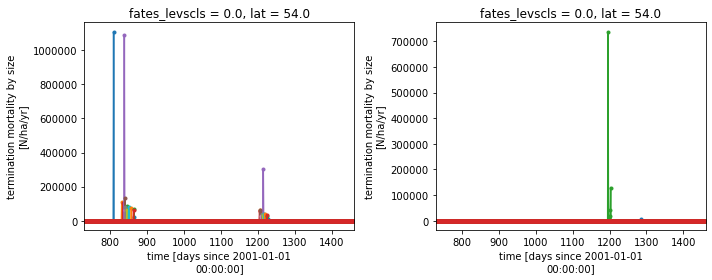

In [11]:
plt.rcParams['figure.figsize'] = [10, 4]
fig,([ax0, ax1]) = plt.subplots(ncols=2, nrows=1)
lats=range(36,37)
lons=range(46,60)
xmn=365*yr1
xmx=365*yr2
ymx=10
for l in lats:
   ds0.M6_SCLS.isel(lat=l,  lon=lons, fates_levscls=0).plot.line(ax=ax0,x='time',add_legend=False, xlim=(xmn,xmx), marker='.')
   ds1.M6_SCLS.isel(lat=l,  lon=lons, fates_levscls=0).plot.line(ax=ax1,x='time',add_legend=False, xlim=(xmn,xmx), marker='.')
plt.tight_layout()
print(lats)

The fluxes in the winter are a little more positive where there is a minimal LAI

Just for good measure, here is the "days since cold leaf off" counter, showing that we apparently only trigger this once

Looking at the status flags, and zooming into the time of the leaf flush in the second year (day 460-480), these look more or less as expected.

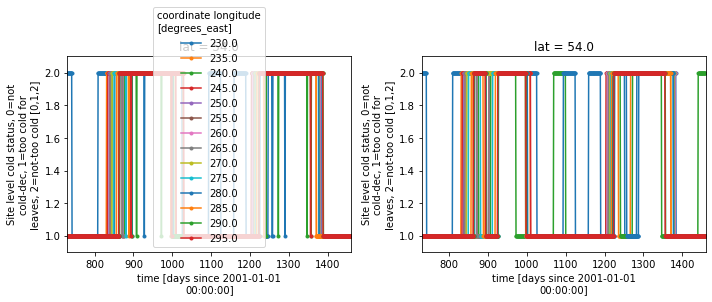

In [12]:
plt.rcParams['figure.figsize'] = [10, 4]
fig,([ax0, ax1]) = plt.subplots(ncols=2, nrows=1)
lats=range(36,37)
lons=range(46,60)
xmn=365*yr1
xmx=365*yr2
ymx=2.1
for l in lats:
   ds0.SITE_COLD_STATUS.isel(lat=l,  lon=lons).plot.line(ax=ax0,x='time', marker='.', xlim=(xmn,xmx), ylim=(0.9,ymx))
   ds1.SITE_COLD_STATUS.isel(lat=l, lon=lons).plot.line(ax=ax1,x='time',add_legend=False, marker='.', xlim=(xmn,xmx), ylim=(0.9,ymx))
plt.tight_layout()


What about the leaf counters? Here we can see that in both cases (pre and post bug fux), there is a secondary leaf flushing event 10 or so days after the first one.  

The first event appears to also be coincident with a zeroing of the leaf'off counter as well as the leaf on?

And only the -second- event appears to be coincident with the change in the leaf status to 2(!!)

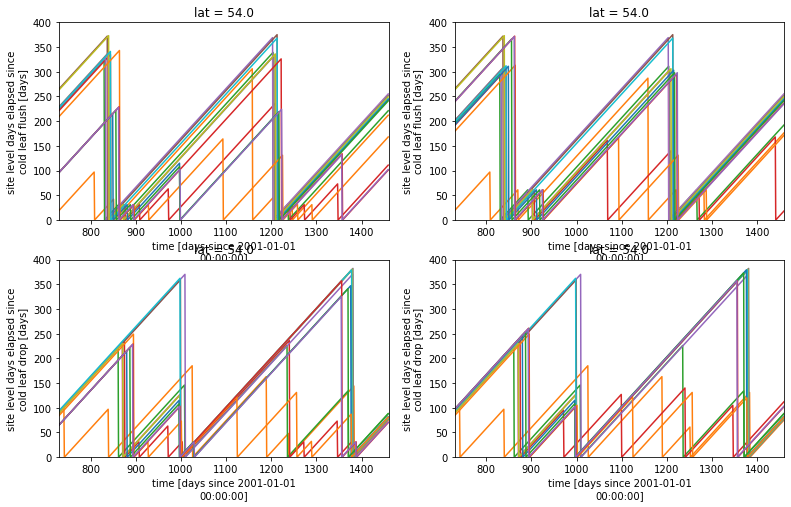

In [13]:
plt.rcParams['figure.figsize'] = [13, 8]
fig,([ax0, ax1],[ax2, ax3]) = plt.subplots(ncols=2, nrows=2)
lats=range(36,37)
lons=range(45,60)
xmn=365*yr1
xmx=365*yr2
ymx=400
for l in lats:
   ds0.SITE_DAYSINCE_COLDLEAFON.isel(lat=l,  lon=lons).plot.line(ax=ax0,x='time',add_legend=False, xlim=(xmn,xmx), ylim=(0,ymx))
   ds1.SITE_DAYSINCE_COLDLEAFON.isel(lat=l, lon=lons).plot.line(ax=ax1,x='time',add_legend=False, xlim=(xmn,xmx), ylim=(0,ymx))
   ds0.SITE_DAYSINCE_COLDLEAFOFF.isel(lat=l,  lon=lons).plot.line(ax=ax2,x='time',add_legend=False, xlim=(xmn,xmx), ylim=(0,ymx))
   ds1.SITE_DAYSINCE_COLDLEAFOFF.isel(lat=l, lon=lons).plot.line(ax=ax3,x='time',add_legend=False, xlim=(xmn,xmx), ylim=(0,ymx))


Here we can see that there is a litterfall event coincident with the second leaf on event, as well as a loss of carbon from the store. (which doesn't happen for the first event)

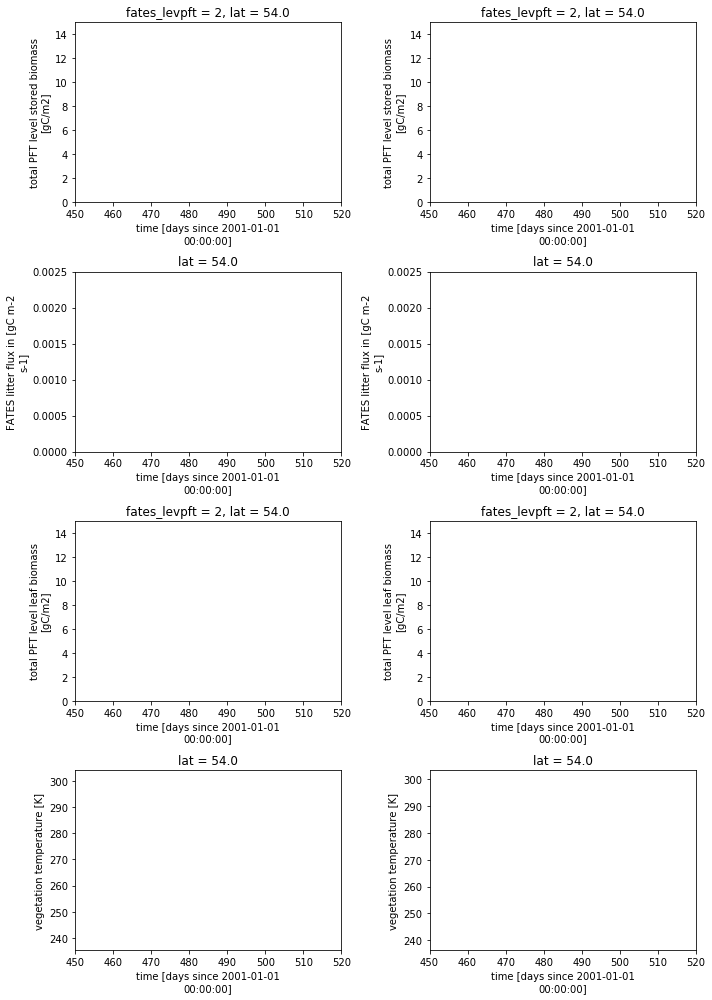

In [14]:
plt.rcParams['figure.figsize'] = [10, 14]
fig,([ax0, ax1],[ax2, ax3],[ax4, ax5],[ax6, ax7]) = plt.subplots(ncols=2, nrows=4)
lats=range(36,37)
lons=range(46,60)
xmn=450 #365*yr1
xmx=520 #365*yr2

ymx2=0.0025
ymx=15
for l in lats:
   ds0.PFTstorebiomass.isel(lat=l,  lon=lons, fates_levpft=1).plot.line(ax=ax0,x='time',add_legend=False, xlim=(xmn,xmx), marker='.',ylim=(0,ymx))
   ds1.PFTstorebiomass.isel(lat=l,  lon=lons, fates_levpft=1).plot.line(ax=ax1,x='time',add_legend=False, xlim=(xmn,xmx), marker='.', ylim=(0,ymx))
   ds0.LITTER_IN.isel(lat=l,  lon=lons).plot.line(ax=ax2,x='time',add_legend=False, marker='.', ylim=(0,ymx2), xlim=(xmn,xmx))
   ds1.LITTER_IN.isel(lat=l,  lon=lons).plot.line(ax=ax3,x='time',add_legend=False, marker='.', ylim=(0,ymx2), xlim=(xmn,xmx))
   ds0.PFTleafbiomass.isel(lat=l,  lon=lons, fates_levpft=1).plot.line(ax=ax4,x='time',add_legend=False, xlim=(xmn,xmx), marker='.',ylim=(0,ymx))
   ds1.PFTleafbiomass.isel(lat=l,  lon=lons, fates_levpft=1).plot.line(ax=ax5,x='time',add_legend=False, xlim=(xmn,xmx), marker='.', ylim=(0,ymx))
   ds0.TV.isel(lat=l,  lon=lons).plot.line(ax=ax6,x='time',add_legend=False, marker='.', xlim=(xmn,xmx))
   ds1.TV.isel(lat=l,  lon=lons).plot.line(ax=ax7,x='time',add_legend=False, marker='.', xlim=(xmn,xmx))
plt.tight_layout()


In [15]:
#np.max(ds0.SITE_GDD.max,0).plot.line(ax=ax0,x='time',add_legend=False, marker='.', xlim=(xmn,xmx), ylim=(0,500))
#np.max(ds1.SITE_GDD.max,0).plot.line(ax=ax1,x='time',add_legend=False, marker='.', xlim=(xmn,xmx), ylim=(0,500))


The two leaf on events must be triggering this line:
https://github.com/rgknox/fates/blob/8e0b059ddc925e58739669f8a45b3a271273a113/biogeochem/EDPhysiologyMod.F90#L699
which is using the growing degree days counter, so what does that look like?

The GDD threshold equation is here
https://github.com/rgknox/fates/blob/8e0b059ddc925e58739669f8a45b3a271273a113/biogeochem/EDPhysiologyMod.F90#L642
ED_val_phen_a + ED_val_phen_^(ED_val_phen_c*real(currentSite%nchilldays,r8))
Check those parameters:

In [16]:
pftfile='/glade/u/home/rfisher/python_scripts/fates_cld.nc'
pfts = xr.open_dataset(pftfile)
print(pfts.fates_phen_a)
print(pfts.fates_phen_b)
print(pfts.fates_phen_c)
print(pfts.fates_phen_chiltemp)
print(pfts.fates_phen_mindayson)


<xarray.DataArray 'fates_phen_a' ()>
array(-68.)
Attributes:
    units:      none
    long_name:  GDD accumulation function, intercept parameter: gdd_thesh = a...
<xarray.DataArray 'fates_phen_b' ()>
array(638.)
Attributes:
    units:      none
    long_name:  GDD accumulation function, multiplier parameter: gdd_thesh = ...
<xarray.DataArray 'fates_phen_c' ()>
array(-0.01)
Attributes:
    units:      none
    long_name:  GDD accumulation function, exponent parameter: gdd_thesh = a ...
<xarray.DataArray 'fates_phen_chiltemp' ()>
array(5.)
Attributes:
    units:      degrees C
    long_name:  chilling day counting threshold
<xarray.DataArray 'fates_phen_mindayson' ()>
array(2592000000000000, dtype='timedelta64[ns]')
Attributes:
    long_name:  day threshold compared against days since leaves became on-al...


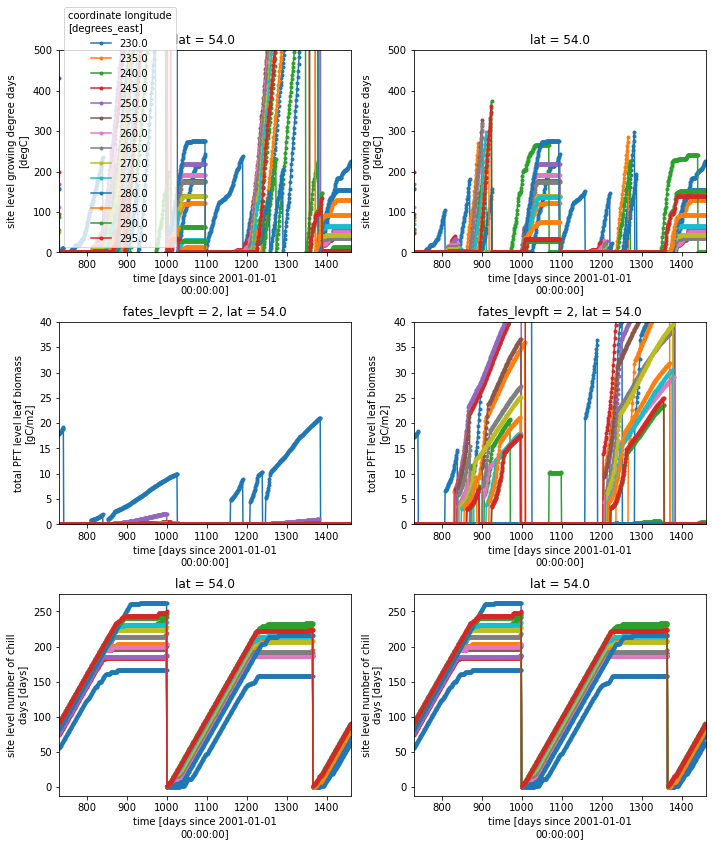

In [17]:
plt.rcParams['figure.figsize'] = [10, 12]
fig,([ax0, ax1],[ax2, ax3],[ax4, ax5]) = plt.subplots(ncols=2, nrows=3)
#xmn=365*yr1
#xmx=365*yr2
lats=range(36,37)
lons=range(46,60)
xmn=365*yr1
xmx=365*yr2
ymx=700
a=-0.001 * ds0.SITE_NCHILLDAYS
b=-0.001 * ds1.SITE_NCHILLDAYS
gdd_th0=-68 + 638*np.exp(a)
gdd_th1=-68 + 638*np.exp(b)
for l in lats:
   ds0.SITE_GDD.isel(lat=l,  lon=lons).plot.line(ax=ax0,x='time', marker='.', xlim=(xmn,xmx), ylim=(0,500))
   ds1.SITE_GDD.isel(lat=l, lon=lons).plot.line(ax=ax1,x='time',add_legend=False, marker='.', xlim=(xmn,xmx), ylim=(0,500))
   ds0.PFTleafbiomass.isel(lat=l,  lon=lons, fates_levpft=1).plot.line(ax=ax2,x='time',add_legend=False, xlim=(xmn,xmx), marker='.',ylim=(0,40))
   ds1.PFTleafbiomass.isel(lat=l,  lon=lons, fates_levpft=1).plot.line(ax=ax3,x='time',add_legend=False, xlim=(xmn,xmx), marker='.', ylim=(0,40))
   ds0.SITE_NCHILLDAYS.isel(lat=l,  lon=lons).plot.line(ax=ax4,x='time',add_legend=False, marker='.', xlim=(xmn,xmx))
   ds1.SITE_NCHILLDAYS.isel(lat=l, lon=lons).plot.line(ax=ax5,x='time',add_legend=False, marker='.', xlim=(xmn,xmx))
  # gdd_th0.isel(lat=l,  lon=lons).plot.line(ax=ax4,x='time',add_legend=False, marker='.', xlim=(xmn,xmx))
  # gdd_th1.isel(lat=l, lon=lons).plot.line(ax=ax5,x='time',add_legend=False, marker='.', xlim=(xmn,xmx))
 
plt.tight_layout()


From this, the GDD counter is zreoing on the first leaf-on event, but not the second? 

It also seems that we shouldn't have reached the GDD threshold yet, if these calcs are right?



----------

In the phenology routine, we diagnose the 'flushfraction' as follows:
min(EDPftvarcon_inst%phenflush_fraction(ipft)*laimemory, store_c)/store_c
here:
https://github.com/rgknox/fates/blob/8e0b059ddc925e58739669f8a45b3a271273a113/biogeochem/EDPhysiologyMod.F90#L940

It occurs to me that if there was some strangeness with laimemory, we might be getting threshold behaviour associated with this min statement which might (or might not) explain the fact that some of the grid cell with higher productivity appear to be functioning as expected. I'm currently testing something which bypasses this logic. Will report back...
